In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import ot
import pandas as pd
import seaborn as sb

from einops import rearrange
from omegaconf import OmegaConf
from pathlib import Path

from lola.data import MiniWellDataset, find_hdf5

os.environ["PATH"] += ":/mnt/sw/nix/store/80wb60hk9c9hbi1rzbnr6kdbbjknp4ch-texlive-20220321/bin/x86_64-linux"

outdir = Path("./figures")
outdir.mkdir(exist_ok=True)

rc = {
    "axes.axisbelow": True,
    "axes.linewidth": 1.0,
    "axes.labelsize": "x-small",
    "axes.titlesize": "x-small",
    "figure.dpi": 150,
    "figure.figsize": (3.2, 3.2),
    "font.size": 12.0,
    "legend.fontsize": "xx-small",
    "lines.linewidth": 1.0,
    "savefig.transparent": True,
    "xtick.labelsize": "xx-small",
    "xtick.major.width": 1.0,
    "ytick.labelsize": "xx-small",
    "ytick.major.width": 1.0,
    "font.family": ["serif"],
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsfonts}",
}

plt.rcParams.update(rc)

In [2]:
# runpath = Path("~/ceph/lola/runs/ae/8brbetky_rayleigh_benard_dcae_f32c4_large/")
# runpath = Path("~/ceph/lola/runs/ae/jiof10wl_rayleigh_benard_dcae_f32c16_large/")
runpath = Path("~/ceph/lola/runs/ae/1e3z5x2c_rayleigh_benard_dcae_f32c64_large/")
runpath = runpath.expanduser()

cfg = OmegaConf.load(runpath / "config.yaml")

In [3]:
files = [
    file
    for physic in cfg.dataset.physics
    for file in find_hdf5(
        path=runpath / "cache" / physic / "train",
        include_filters=cfg.dataset.include_filters,
    )
]

dataset = MiniWellDataset.from_files(
    files=files,
    steps=1,
    stride=1,
)

In [4]:
data = {}

for d in dataset.datasets:
    key = d.file["label"][0, :2]
    key = np.exp(key).tolist()
    key = (f"{key[0]:.0e}", float(f"{key[1]:.2f}"))

    x = d.file["state"][::4, 50::25, :, 8, 2]
    x = rearrange(x, "N L C -> (N L) C")

    data[key] = x

data = dict(sorted(data.items()))

In [5]:
X = np.concatenate([v for k, v in data.items()])
Y = np.array([[k] * len(v) for k, v in data.items()]).reshape(-1, 2)

labels, classes = np.unique(Y, axis=0, return_inverse=True)

## Separability

In [6]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(64, 16, 4), max_iter=4096, random_state=42).fit(X, classes)

activations = [x] + [None] * (mlp.n_layers_ - 1)
activations = mlp._forward_pass(activations)

X_mlp = activations[-2]

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_mlp)

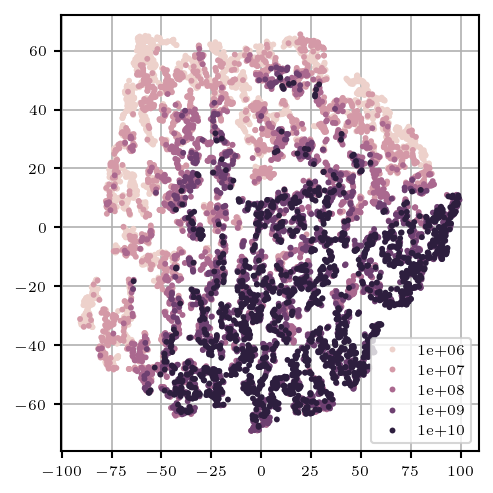

In [8]:
fig = plt.figure(figsize=(3.2, 3.2))

ax = sb.scatterplot(x=X_tsne[..., 0], y=X_tsne[..., 1], hue=Y[:, 0], palette=sb.cubehelix_palette(5), linewidth=0, s=8)
ax.grid()

fig.tight_layout(pad=0.33)

plt.savefig(outdir / "rb_tsne_rayleigh.pdf", dpi=300, transparent=True)

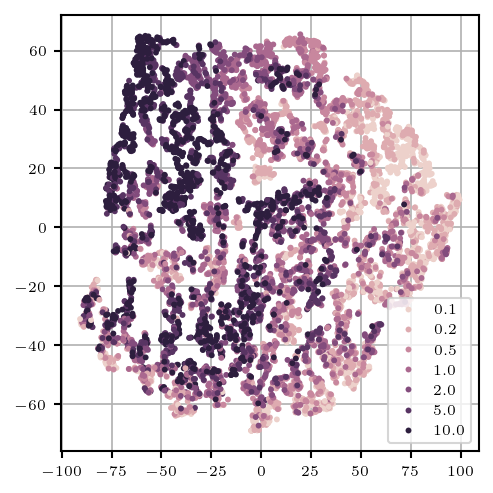

In [9]:
fig = plt.figure(figsize=(3.2, 3.2))

ax = sb.scatterplot(x=X_tsne[..., 0], y=X_tsne[..., 1], hue=Y[:, 1], palette=sb.cubehelix_palette(7), linewidth=0, s=8)
ax.grid()

fig.tight_layout(pad=0.33)

plt.savefig(outdir / "rb_tsne_prandtl.pdf", dpi=300, transparent=True)

## Bures-Wasserstein distance

In [10]:
view = {}

for k, v in data.items():
    view.setdefault(k[0], []).append(v)  # 0 for Rayleigh

view = {k: np.concatenate(v) for k, v in view.items()}
means = {k: np.mean(v, axis=0) for k, v in view.items()}
covs = {k: np.cov(v.T) for k, v in view.items()}

rows = []

for a in view:
    for b in view:
        dist = ot.gaussian.bures_wasserstein_distance(means[a], means[b], covs[a], covs[b])
        rows.append([a, b, round(dist.item(), 3)])

df = pd.DataFrame(rows, columns=["a", "b", "dist"])
df.pivot(index="a", columns="b", values="dist")

b,1e+06,1e+07,1e+08,1e+09,1e+10
a,,,,,
1e+06,0.000,1.045,1.708,2.279,2.489
1e+07,1.045,0.000,0.965,1.537,1.794
1e+08,1.708,0.965,0.000,0.915,1.180
1e+09,2.279,1.537,0.915,0.000,0.714
1e+10,2.489,1.794,1.180,0.714,0.000


In [11]:
view = {}

for k, v in data.items():
    view.setdefault(k[1], []).append(v)  # 1 for Prandtl

view = {k: np.concatenate(v) for k, v in view.items()}
means = {k: np.mean(v, axis=0) for k, v in view.items()}
covs = {k: np.cov(v.T) for k, v in view.items()}

rows = []

for a in view:
    for b in view:
        dist = ot.gaussian.bures_wasserstein_distance(means[a], means[b], covs[a], covs[b])
        rows.append([float(a), float(b), round(dist.item(), 3)])

df = pd.DataFrame(rows, columns=["a", "b", "dist"])
df.pivot(index="a", columns="b", values="dist")

b,0.1,0.2,0.5,1.0,2.0,5.0,10.0
a,,,,,,,
0.1,0.000,1.367,2.042,2.631,3.244,3.884,4.210
0.2,1.367,0.000,1.269,1.839,2.381,3.007,3.331
0.5,2.042,1.269,0.000,0.986,1.479,2.093,2.398
1.0,2.631,1.839,0.986,0.000,0.930,1.472,1.766
2.0,3.244,2.381,1.479,0.930,0.000,0.988,1.251
5.0,3.884,3.007,2.093,1.472,0.988,0.000,0.711
10.0,4.210,3.331,2.398,1.766,1.251,0.711,0.000
